In [1]:
# ------------------------------------------------------------------------
#
# TITLE - pwfs_focus.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1500
#
# ------------------------------------------------------------------------
#
# Docstrings and metadata:
''' Assess the region of impact of a DM poke on the PWFS
'''

__author__ = "James Lane"

In [2]:
### Imports

## Basic
%run ../../src/_helpers/basic_imports.py

## Plotting
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import colors
from matplotlib import cm

## Scipy
import scipy.io

## Project-specific
sys.path.insert(0,'../../src/')
# import project_module.sub_module

Basic imports:
numpy as np, sys, os, copy, glob, subprocess,
matplotlib.pyplot as plt, matplotlib as mpl, astropy.units as apu


In [3]:
### Notebook setup

## Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Debugging, 
# to automatically drop in during error use %pdb
from IPython.core.debugger import set_trace

In [4]:
n_actuator = 97
base_directory = '../../data/pwfs_focus/August22/'
show_plots = False
aoe_peak_fraction = 0.1

In [5]:
def make_actuator_map(data,actuator_indices,no_actuator_value=0.0):
    
    assert len(data) == 97 and len(actuator_indices) == 97, 'Must be size 97!'
    
    # Make a map from actuator number into 2D location
    actuator_mapping = np.array([
        [0,0,0,1,2,3,4,5,0,0,0],
        [0,0,6,7,8,9,10,11,12,0,0],
        [0,13,14,15,16,17,18,19,20,21,0],
        [22,23,24,25,26,27,28,29,30,31,32],
        [33,34,35,36,37,38,39,40,41,42,43],
        [44,45,46,47,48,49,50,51,52,53,54],
        [55,56,57,58,59,60,61,62,63,64,65],
        [66,67,68,69,70,71,72,73,74,75,76],
        [0,77,78,79,80,81,82,83,84,85,0],
        [0,0,86,87,88,89,90,91,92,0,0],
        [0,0,0,94,94,95,96,97,0,0,0]
    ]).T
    
    where_no_actuator = np.where(actuator_mapping==0)
    new_map = np.zeros_like(actuator_mapping,dtype='float')
    new_map[where_no_actuator] = no_actuator_value
    
    for i in range( len(actuator_indices) ):
        cur_actuator_ind = actuator_indices[i]
        where_in_actuator_map = np.where( actuator_mapping == cur_actuator_ind )
        new_map[where_in_actuator_map] = data[i]
    ###i
    
    return new_map
#def

# SHWFS

In [6]:
shwfs_x_slopes_flat = scipy.io.loadmat(base_directory+'SHWFS_Slopes/DMActuator_flat_SlopeX.mat')['sX'] 
shwfs_y_slopes_flat = scipy.io.loadmat(base_directory+'SHWFS_Slopes/DMActuator_flat_SlopeY.mat')['sY']

f_x_slopes_shwfs = np.zeros(n_actuator)
f_y_slopes_shwfs = np.zeros(n_actuator)

for i in range(n_actuator):
    
    x_slopes = scipy.io.loadmat(base_directory+'SHWFS_Slopes/DMActuator'+str(i+1)+'_SlopeX.mat')['sX'] 
    y_slopes = scipy.io.loadmat(base_directory+'SHWFS_Slopes/DMActuator'+str(i+1)+'_SlopeY.mat')['sY']
    
    x_slopes = x_slopes - shwfs_x_slopes_flat
    y_slopes = y_slopes - shwfs_y_slopes_flat
    
    x_slopes = np.abs(x_slopes)
    y_slopes = np.abs(y_slopes)
    
    x_slopes[ x_slopes < np.max(x_slopes)*aoe_peak_fraction ] = 0
    y_slopes[ y_slopes < np.max(y_slopes)*aoe_peak_fraction ] = 0
    
    f_x_slopes_shwfs[i] = len( np.where( x_slopes )[0] ) / len( x_slopes ) 
    f_y_slopes_shwfs[i] = len( np.where( y_slopes )[0] ) / len( y_slopes ) 
    
    if show_plots:
        fig = plt.figure(figsize=(8,4))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        ax1.scatter( np.arange(0,len(x_slopes))+1, x_slopes, color='DodgerBlue', s=1 )
        ax2.scatter( np.arange(0,len(y_slopes))+1, y_slopes, color='DarkRed', s=1 )

        ax1.set_ylim(-0.01,0.01)
        ax2.set_ylim(-0.01,0.01)

        fig.suptitle('Actuator '+str(i+1))
        fig.set_facecolor('White')
        plt.show()
        plt.clf()
    ##fi
###i

# PWFS

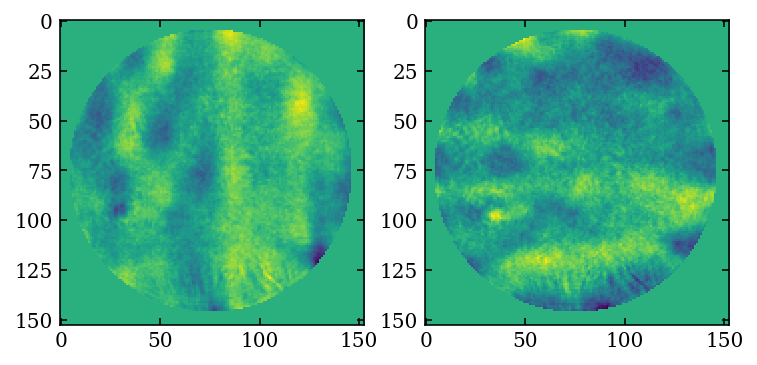

In [7]:
x_slopes = scipy.io.loadmat(base_directory+'PWFS_Slopes/DMActuator1_SlopeX.mat')['Sx']
y_slopes = scipy.io.loadmat(base_directory+'PWFS_Slopes/DMActuator1_SlopeY.mat')['Sy']

all_x_slopes = np.zeros_like(x_slopes)
all_y_slopes = np.zeros_like(y_slopes)

for i in range(n_actuator):
    
    x_slopes = scipy.io.loadmat(base_directory+'PWFS_Slopes/DMActuator'+str(i+1)+'_SlopeX.mat')['Sx']
    y_slopes = scipy.io.loadmat(base_directory+'PWFS_Slopes/DMActuator'+str(i+1)+'_SlopeY.mat')['Sy']
    
    all_x_slopes += x_slopes
    all_y_slopes += y_slopes
    
###i

all_x_slopes = all_x_slopes / n_actuator
all_y_slopes = all_y_slopes / n_actuator

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(all_x_slopes)
ax2.imshow(all_y_slopes)

fig.set_facecolor('White')
plt.show()
plt.clf()

In [8]:
# Number of pixels in a PWFS pupil
n_pixels_in_pupil_x = np.where(all_x_slopes.flatten() != 0.0)[0].shape[0]
n_pixels_in_pupil_y = np.where(all_y_slopes.flatten() != 0.0)[0].shape[0]

In [9]:
if base_directory[-9:] == 'August22/':
    pwfs_x_slopes_flat = scipy.io.loadmat(base_directory+'PWFS_Slopes/DMActuator_flat_SlopeX.mat')['Sx'] 
    pwfs_y_slopes_flat = scipy.io.loadmat(base_directory+'PWFS_Slopes/DMActuator_flat_SlopeY.mat')['Sy']
##fi
if base_directory[-9:] == '/August1/':
    pwfs_x_slopes_flat = all_x_slopes
    pwfs_y_slopes_flat = all_x_slopes
##fi
    
f_x_slopes_pwfs = np.zeros(n_actuator)
f_y_slopes_pwfs = np.zeros(n_actuator)

for i in range(n_actuator):
    
    x_slopes = scipy.io.loadmat(base_directory+'PWFS_Slopes/DMActuator'+str(i+1)+'_SlopeX.mat')['Sx']
    y_slopes = scipy.io.loadmat(base_directory+'PWFS_Slopes/DMActuator'+str(i+1)+'_SlopeY.mat')['Sy']
    
    x_slopes = x_slopes - all_x_slopes
    y_slopes = y_slopes - all_y_slopes
    
    x_slopes = np.abs(x_slopes) 
    y_slopes = np.abs(y_slopes) 
    
    x_slopes[ x_slopes < np.max(x_slopes)*aoe_peak_fraction ] = 0
    y_slopes[ y_slopes < np.max(y_slopes)*aoe_peak_fraction ] = 0
    
    n_pixels_influence_x = len(np.where( x_slopes.flatten() > 0 )[0])
    n_pixels_influence_y = len(np.where( y_slopes.flatten() > 0 )[0])
    
    f_x_slopes_pwfs[i] = n_pixels_influence_x / n_pixels_in_pupil_x
    f_y_slopes_pwfs[i] = n_pixels_influence_y / n_pixels_in_pupil_y
    
    if show_plots:
        fig = plt.figure(figsize=(8,4))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        
        ax1.imshow( x_slopes )
        ax2.imshow( y_slopes )

        fig.suptitle('Actuator '+str(i+1))
        fig.set_facecolor('White')
        plt.show()
        plt.clf()
    ##fi
###i 

# Plot up the results

## First test the plotting script

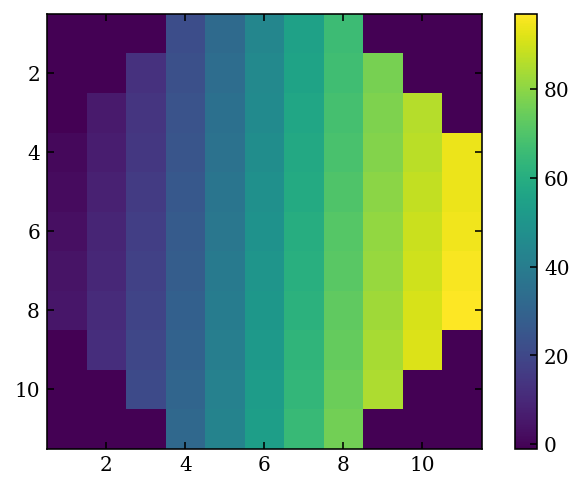

In [55]:
actuator_indices = np.arange(0,n_actuator)+1

actuator_map_test = make_actuator_map(actuator_indices,actuator_indices,
                                      no_actuator_value=-1.0)

fig = plt.figure()
ax = fig.add_subplot(111)

im=ax.imshow(actuator_map_test,extent=(0.5,11.5,11.5,0.5))
fig.colorbar(im)
fig.set_facecolor('White')

plt.show()

In [56]:
actuator_indices = np.arange(0,n_actuator)+1
f_x_slopes_shwfs_map = make_actuator_map(f_x_slopes_shwfs,actuator_indices,
                                         no_actuator_value=0.0)
f_y_slopes_shwfs_map = make_actuator_map(f_y_slopes_shwfs,actuator_indices,
                                         no_actuator_value=0.0)

f_x_slopes_pwfs_map = make_actuator_map(f_x_slopes_pwfs,actuator_indices,
                                         no_actuator_value=0.0)
f_y_slopes_pwfs_map = make_actuator_map(f_y_slopes_pwfs,actuator_indices,
                                         no_actuator_value=0.0)

f_x_perc_diff = 100*np.divide(f_x_slopes_pwfs-f_x_slopes_shwfs,f_x_slopes_shwfs)
f_y_perc_diff = 100*np.divide(f_y_slopes_pwfs-f_y_slopes_shwfs,f_y_slopes_shwfs)

f_x_perc_diff_map = make_actuator_map(f_x_perc_diff,actuator_indices,
                                         no_actuator_value=-100.0)
f_y_perc_diff_map = make_actuator_map(f_x_perc_diff,actuator_indices,
                                         no_actuator_value=-100.0)

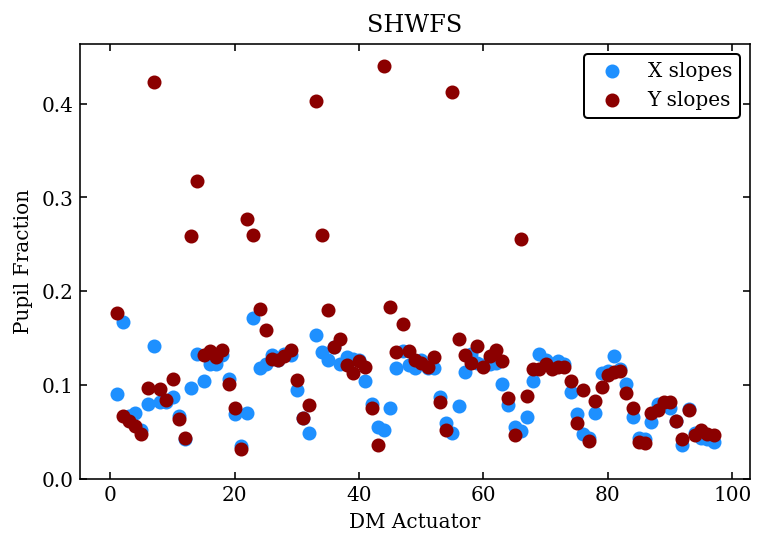

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter( np.arange(0,n_actuator)+1, f_x_slopes_shwfs, color='DodgerBlue', label='X slopes')
ax.scatter( np.arange(0,n_actuator)+1, f_y_slopes_shwfs, color='DarkRed', label='Y slopes')
ax.legend()

ax.set_xlabel('DM Actuator')
ax.set_ylabel('Pupil Fraction')
ax.set_title('SHWFS')

fig.set_facecolor('White')
plt.savefig('shwfs_dm_poke_area.png')
plt.show()
plt.clf()

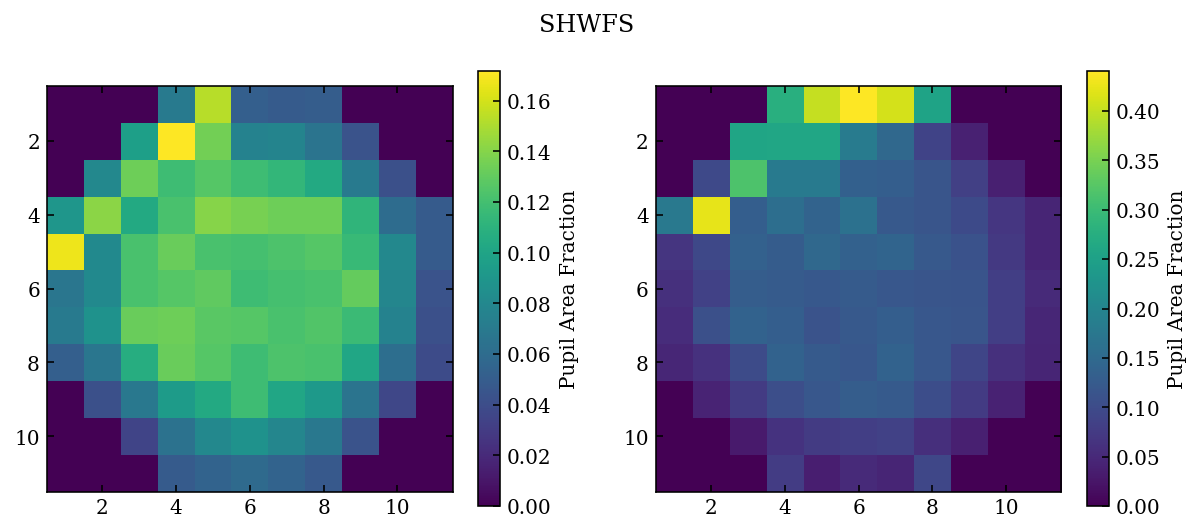

In [58]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

im1 = ax1.imshow(f_x_slopes_shwfs_map, extent=(0.5,11.5,11.5,0.5))
im2 = ax2.imshow(f_y_slopes_shwfs_map, extent=(0.5,11.5,11.5,0.5))
cb1 = fig.colorbar(im1, ax=ax1)
cb2 = fig.colorbar(im2, ax=ax2)

cb1.set_label('Pupil Area Fraction')
cb2.set_label('Pupil Area Fraction')

fig.set_facecolor('White')
fig.suptitle('SHWFS')

plt.savefig('shwfs_dm_poke_area_map.png')
plt.show()
plt.clf()

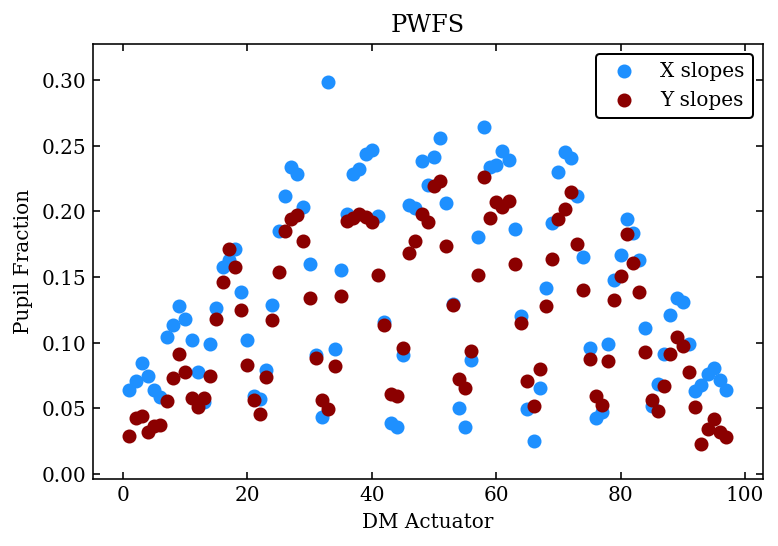

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter( np.arange(0,n_actuator)+1, f_x_slopes_pwfs, color='DodgerBlue', label='X slopes')
ax.scatter( np.arange(0,n_actuator)+1, f_y_slopes_pwfs, color='DarkRed', label='Y slopes')
ax.legend()

ax.set_xlabel('DM Actuator')
ax.set_ylabel('Pupil Fraction')
ax.set_title('PWFS')

fig.set_facecolor('White')
plt.savefig('pwfs_dm_poke_area.png')
plt.show()
plt.clf()

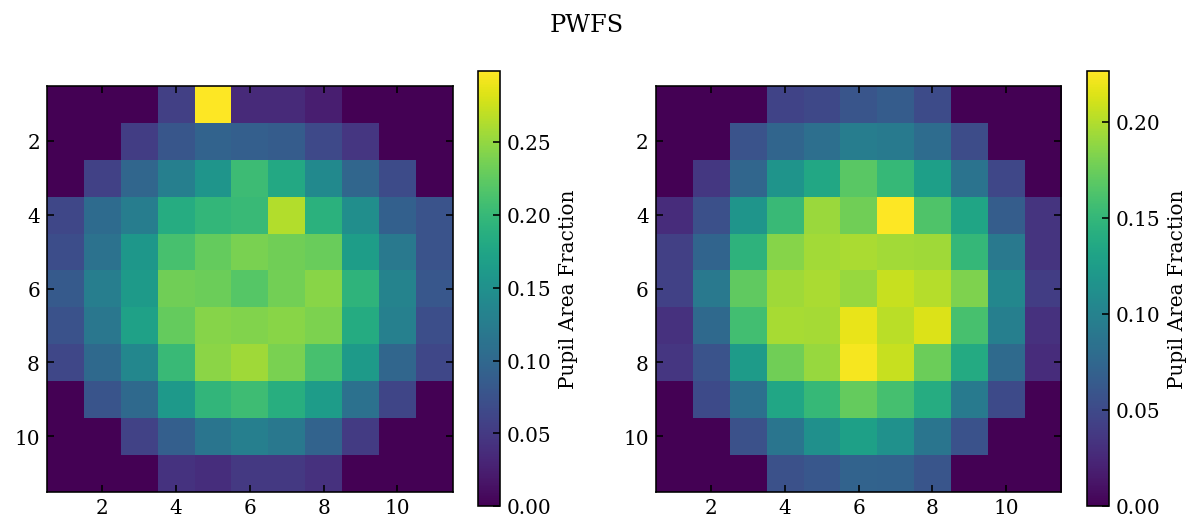

In [60]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

im1 = ax1.imshow(f_x_slopes_pwfs_map, extent=(0.5,11.5,11.5,0.5))
im2 = ax2.imshow(f_y_slopes_pwfs_map, extent=(0.5,11.5,11.5,0.5))
cb1 = fig.colorbar(im1, ax=ax1)
cb2 = fig.colorbar(im2, ax=ax2)

cb1.set_label('Pupil Area Fraction')
cb2.set_label('Pupil Area Fraction')

fig.set_facecolor('White')
fig.suptitle('PWFS')

plt.savefig('pwfs_dm_poke_area_map.png')
plt.show()
plt.clf()

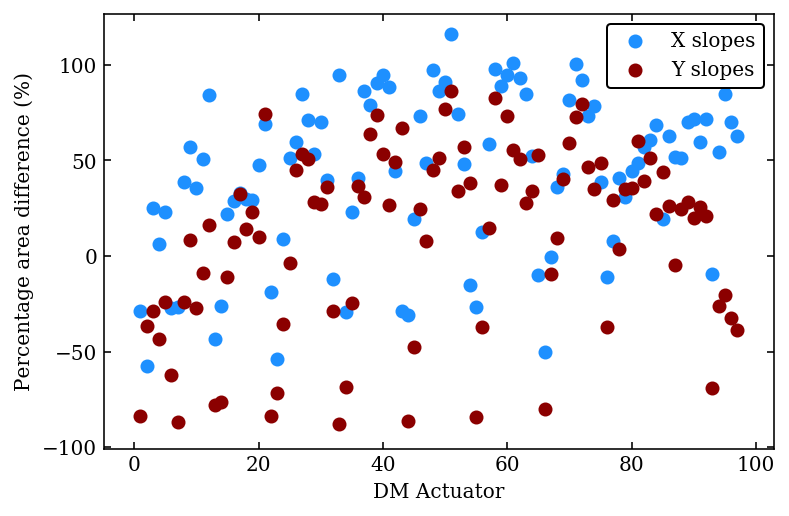

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter( np.arange(0,n_actuator)+1, 
           100*np.divide(f_x_slopes_pwfs-f_x_slopes_shwfs,f_x_slopes_shwfs), 
           color='DodgerBlue', label='X slopes')
ax.scatter( np.arange(0,n_actuator)+1, 
           100*np.divide(f_y_slopes_pwfs-f_y_slopes_shwfs,f_y_slopes_shwfs), 
           color='DarkRed', label='Y slopes')
ax.legend()

ax.set_xlabel('DM Actuator')
ax.set_ylabel(r'Percentage area difference (%)')

fig.set_facecolor('White')
plt.savefig('difference_dm_poke_area.png')
plt.show()
plt.clf()

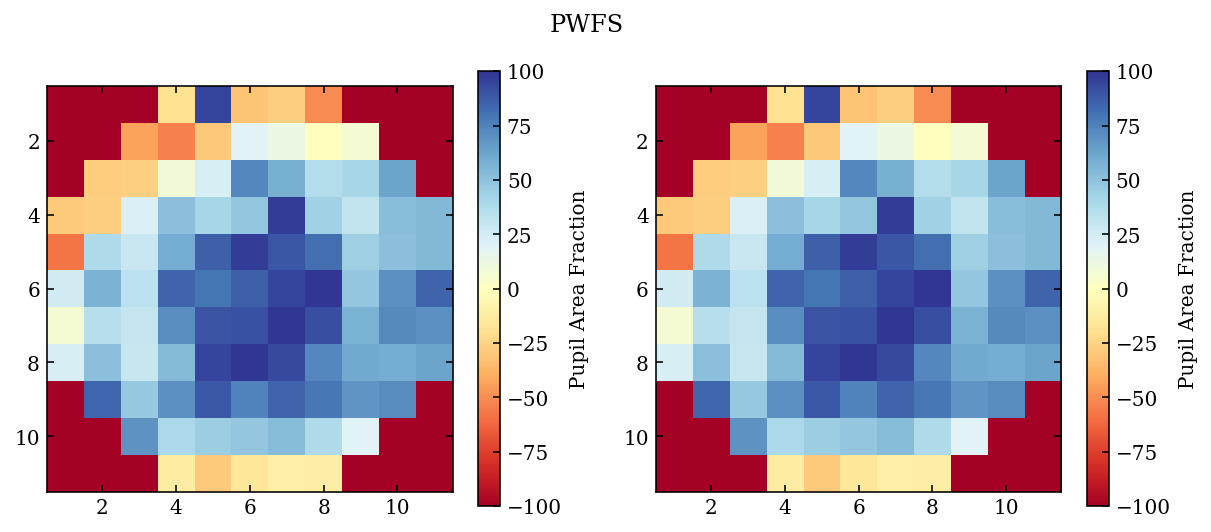

In [62]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

im1 = ax1.imshow(f_x_perc_diff_map, extent=(0.5,11.5,11.5,0.5), vmin=-100, vmax=100, 
                cmap='RdYlBu')
im2 = ax2.imshow(f_y_perc_diff_map, extent=(0.5,11.5,11.5,0.5), vmin=-100, vmax=100,
                cmap='RdYlBu')
cb1 = fig.colorbar(im1, ax=ax1)
cb2 = fig.colorbar(im2, ax=ax2)

cb1.set_label('Pupil Area Fraction')
cb2.set_label('Pupil Area Fraction')

fig.set_facecolor('White')
fig.suptitle('PWFS')

plt.savefig('difference_dm_poke_area_map.png')
plt.show()
plt.clf()